In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from numpy.testing import assert_allclose

sys.path.append("../")

import refellips
from refellips.dataSE import DataSE
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE
from refellips.dispersion import Cauchy, RI, load_material

In [4]:
%matplotlib inline

# Test 1

Check bare interface ellipsometry calcualtion against wvase

Test passed


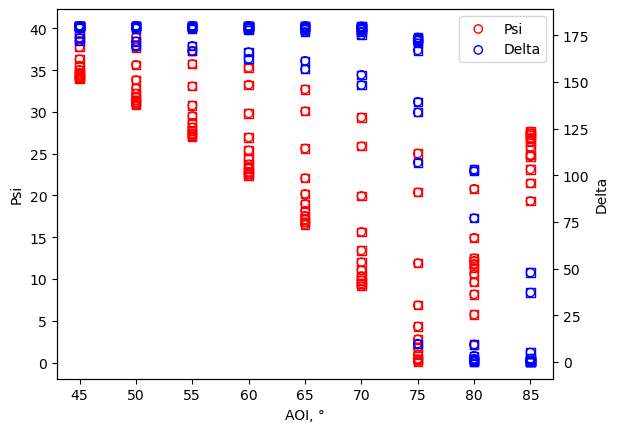

In [5]:
dname = "TestData_bareSI.txt"
data = DataSE(data=dname)

si = RI("../materials/silicon.csv")
void = RI("../materials/void.csv")
struc = void() | si()
model = ReflectModelSE(struc)

fig, ax = plt.subplots()
axt = ax.twinx()
test_arr = []

for idx, wav in enumerate(np.unique(data.wavelength)):
    wavelength, aoi, d_psi, d_delta = list(data.unique_wavelength_data())[idx]
    psi, delta = model(np.c_[np.ones_like(aoi) * wavelength, aoi])

    ax.scatter(aoi, psi, facecolor="none", color="r", marker="s")
    p = ax.scatter(aoi, d_psi, facecolor="none", color="r")
    test_arr.append(np.abs(np.array(psi - d_psi) / d_psi) < 0.005)
    test_arr.append(np.abs(np.array(delta - d_delta) / d_delta) < 0.005)

    axt.scatter(aoi, delta, facecolor="none", color="b", marker="s")
    d = axt.scatter(aoi, d_delta, facecolor="none", color="b")

    ax.legend(handles=[p, d], labels=["Psi", "Delta"])
    ax.set(ylabel="Psi", xlabel="AOI, °")
    axt.set(ylabel="Delta")

test_arr = np.array(test_arr)

if np.prod(test_arr, dtype=bool):
    print("Test passed")
else:
    print("test failed")

# Test 2
Check the cauchy model behaves as expected

test passed


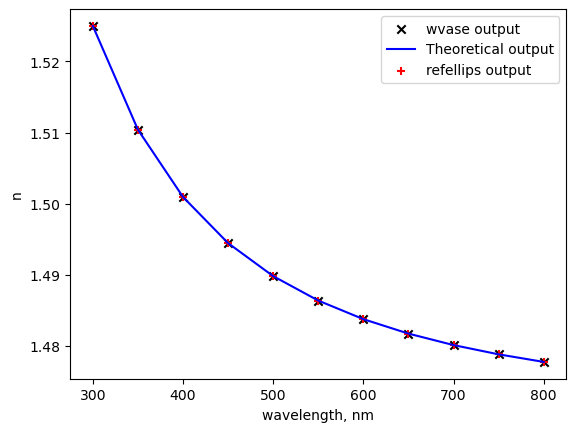

In [6]:
fig, ax = plt.subplots()

A = 1.47
B = 0.00495
C = 0

si = RI("../materials/silicon.csv")
void = RI("../materials/void.csv")
cauchy = Cauchy(A=A, B=B, C=C)
struc = void() | cauchy(1000) | si()
model = ReflectModelSE(struc)
model._flip_delta = True

wvase_output = np.loadtxt("Cauchynk_fromWVASE.txt")
wavs = wvase_output[:, 0]
refin = A + B / ((wavs / 1000) ** 2) + C / ((wavs / 1000) ** 4)

ax.scatter(
    wvase_output[:, 0],
    wvase_output[:, 1],
    marker="x",
    color="k",
    label="wvase output",
)
ax.plot(wavs, refin, color="b", label="Theoretical output")


refellips_RI = []
for wav in wavs:
    refellips_RI.append(cauchy.complex(wav).real)

ax.scatter(wavs, refellips_RI, color="r", marker="+", label="refellips output")

ax.set(ylabel="n", xlabel="wavelength, nm")
ax.legend()

passarr_wvase = (
    np.abs(refellips_RI - wvase_output[:, 1]) / wvase_output[:, 1] < 0.01
)
passarr_theory = np.abs(refellips_RI - refin) / refin < 0.01

if np.all([passarr_wvase, passarr_theory]):
    print("test passed")
else:
    print("test failed")

# Test 3
Three layer stack (cauchy & from file) compared to wvase

Also tests behaviour of Delta around 180°

Test passed


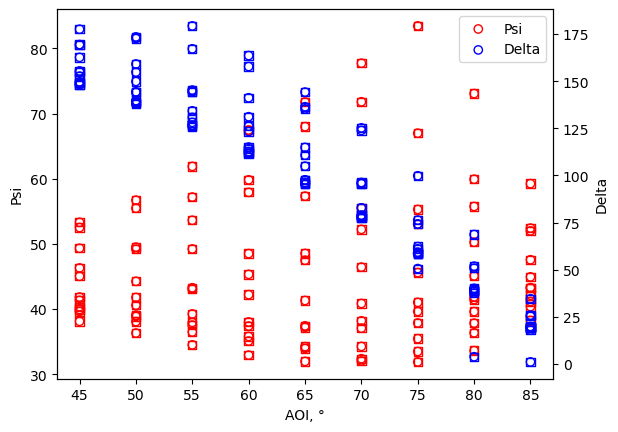

In [7]:
dname = "TestData_cauchy.txt"
data = DataSE(data=dname)

si = RI("../materials/silicon.csv")
void = RI("../materials/void.csv")
cauchy = Cauchy(A=1.47, B=0.00495, C=0)
struc = void() | cauchy(1000) | si()
model = ReflectModelSE(struc)
model._flip_delta = True  # This will be automatically set when analysing data

fig, ax = plt.subplots()
axt = ax.twinx()
test_arr = []

for idx, wav in enumerate(np.unique(data.wavelength)):
    wavelength, aoi, d_psi, d_delta = list(data.unique_wavelength_data())[idx]
    psi, delta = model(np.c_[np.ones_like(aoi) * wavelength, aoi])
    ax.scatter(aoi, psi, facecolor="none", color="r", marker="s")
    p = ax.scatter(aoi, d_psi, facecolor="none", color="r")
    test_arr.append(np.abs(np.array(psi - d_psi) / d_psi) < 0.005)
    test_arr.append(np.abs(np.array(delta - d_delta) / d_delta) < 0.005)

    axt.scatter(aoi, delta, facecolor="none", color="b", marker="s")
    d = axt.scatter(aoi, d_delta, facecolor="none", color="b")

    ax.legend(handles=[p, d], labels=["Psi", "Delta"])
    ax.set(ylabel="Psi", xlabel="AOI, °")
    axt.set(ylabel="Delta")

test_arr = np.array(test_arr)

if np.prod(test_arr, dtype=bool):
    print("Test passed")
else:
    print("test failed")

# Test 4
A 30 nm SiO$_2$ film with ambient as water compared to WVASE

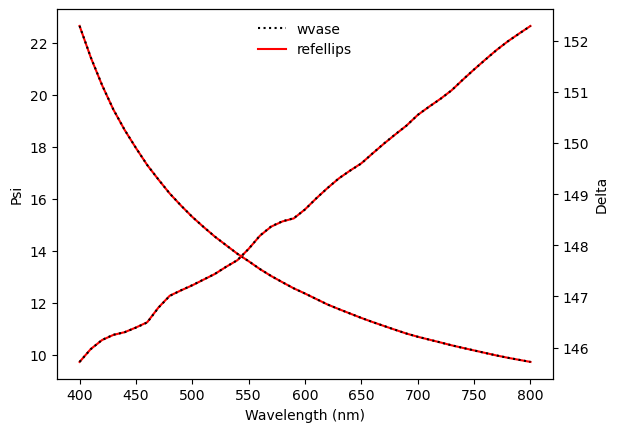

In [8]:
data = DataSE("WVASE_example_30nmSiO2_Water_MultiWavelength.txt")

si = RI("../materials/silicon.csv")
sio2 = RI("../materials/silica.csv")
h2o = RI("../materials/water.csv")

struc = h2o() | sio2(300) | si()
struc.solvent = h2o

model = ReflectModelSE(struc, delta_offset=0)
model._flip_delta = True

fig, ax = plt.subplots()
axt = ax.twinx()

wavelength, aoi, d_psi, d_delta = data.data
psi, delta = model(np.c_[wavelength, np.ones_like(wavelength) * aoi])

ax.plot(wavelength, d_psi, ls="dotted", color="k", label="wvase", zorder=3)
axt.plot(wavelength, d_delta, ls="dotted", color="k", zorder=3)
ax.plot(wavelength, psi, color="r", label="refellips")
axt.plot(wavelength, delta, color="r")

ax.legend(frameon=False, loc="upper center")
ax.set(ylabel="Psi", xlabel="Wavelength (nm)")
axt.set(ylabel="Delta")

assert_allclose(psi, d_psi, rtol=5e-4)
assert_allclose(delta, d_delta, rtol=5e-5)

# Test 5
A 3 nm SiO$_2$ film with 30 % water compared to WVASE

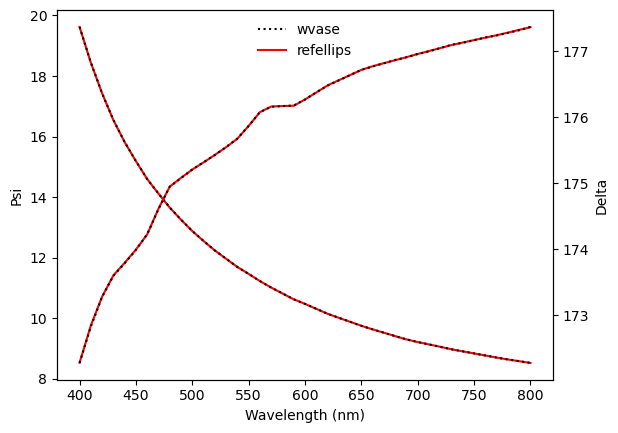

In [9]:
data = DataSE("WVASE_example_3nmSiO2_30EMA_MultiWavelength.txt")

si = RI("../materials/silicon.csv")
sio2 = RI("../materials/silica.csv")
h2o = RI("../materials/water.csv")

silica = sio2(30)
silica.name = "Silica"
silica.vfsolv.setp(value=0.3)

struc = h2o() | silica | si()
struc.solvent = h2o
struc.ema_method = "linear"

model = ReflectModelSE(struc, delta_offset=0)
model._flip_delta = True

fig, ax = plt.subplots()
axt = ax.twinx()

wavelength, aoi, d_psi, d_delta = data.data
psi, delta = model(np.c_[wavelength, np.ones_like(wavelength) * aoi])

ax.plot(wavelength, d_psi, ls="dotted", color="k", label="wvase", zorder=3)
axt.plot(wavelength, d_delta, ls="dotted", color="k", zorder=3)
ax.plot(wavelength, psi, color="r", label="refellips")
axt.plot(wavelength, delta, color="r")

ax.legend(frameon=False, loc="upper center")
ax.set(ylabel="Psi", xlabel="Wavelength (nm)")
axt.set(ylabel="Delta")

assert_allclose(psi, d_psi, rtol=6e-4)
assert_allclose(delta, d_delta, rtol=1e-4)

# Test 6
A comparison to WVASE for a 2 nm SiO$_2$ and 20 nm polymer film system with a 50 % volume fraction of solvent in the polymer film.

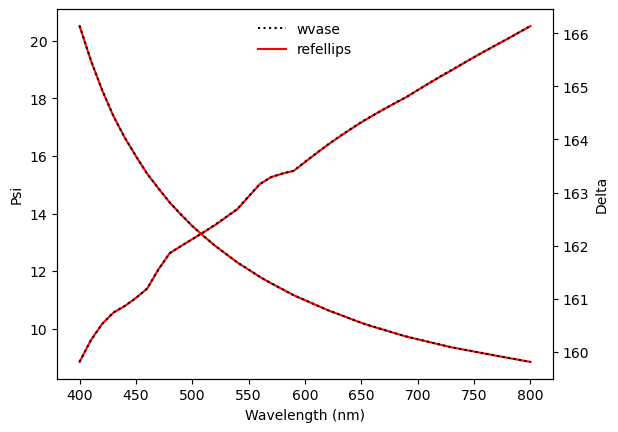

In [10]:
data = DataSE("WVASE_example_2nmSiO2_20nmPNIPAM_50EMA_MultiWavelength.txt")

si = RI("../materials/silicon.csv")
sio2 = RI("../materials/silica.csv")
polymer = Cauchy(A=1.47, B=0.00495)
h2o = Cauchy(A=1.3242, B=0.003064)

polymer_layer = polymer(200)
polymer_layer.name = "PNIPAM"
polymer_layer.vfsolv.setp(value=0.5)

struc = h2o() | polymer_layer | sio2(20) | si()
struc.solvent = h2o
struc.ema = "linear"

model = ReflectModelSE(struc, delta_offset=0)
model._flip_delta = True

fig, ax = plt.subplots()
axt = ax.twinx()

wavelength, aoi, d_psi, d_delta = data.data
psi, delta = model(np.c_[wavelength, np.ones_like(wavelength) * aoi])

ax.plot(wavelength, d_psi, ls="dotted", color="k", label="wvase", zorder=3)
axt.plot(wavelength, d_delta, ls="dotted", color="k", zorder=3)
ax.plot(wavelength, psi, color="r", label="refellips")
axt.plot(wavelength, delta, color="r")

ax.legend(frameon=False, loc="upper center")
ax.set(ylabel="Psi", xlabel="Wavelength (nm)")
axt.set(ylabel="Delta")

assert_allclose(psi, d_psi, rtol=6e-4)
assert_allclose(delta, d_delta, rtol=6e-4)

# Test 7
A comparison to WVASE for a 2 nm SiO$_2$ and 117 nm gold film in air.

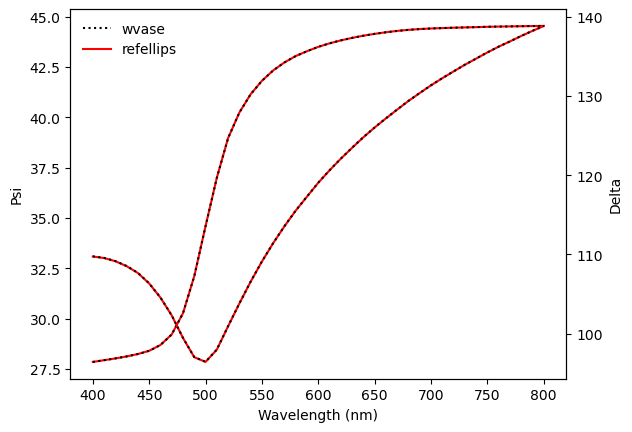

In [11]:
data = DataSE("WVASE_example_2nmSiO2_117nmAu_MultiWavelength.txt")

si = RI("../materials/silicon.csv")
sio2 = RI("../materials/silica.csv")
gold = RI("../materials/gold.csv")
air = RI("../materials/air.csv")

struc = air() | gold(1170) | sio2(20) | si()

model = ReflectModelSE(struc, delta_offset=0)
model._flip_delta = True

fig, ax = plt.subplots()
axt = ax.twinx()

wavelength, aoi, d_psi, d_delta = data.data
psi, delta = model(np.c_[wavelength, np.ones_like(wavelength) * aoi])

ax.plot(wavelength, d_psi, ls="dotted", color="k", label="wvase", zorder=3)
axt.plot(wavelength, d_delta, ls="dotted", color="k", zorder=3)
ax.plot(wavelength, psi, color="r", label="refellips")
axt.plot(wavelength, delta, color="r")

ax.legend(frameon=False)
ax.set(ylabel="Psi", xlabel="Wavelength (nm)")
axt.set(ylabel="Delta")

assert_allclose(psi, d_psi, rtol=3e-5)
assert_allclose(delta, d_delta, rtol=3e-4)

# Test 8
A comparison to WVASE for a 2 nm SiO$_2$ and 65 nm aluminium oxide film in air.

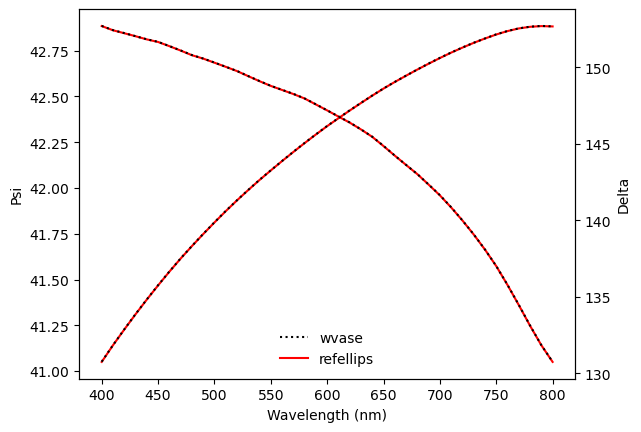

In [12]:
data = DataSE("WVASE_example_2nmSiO2_65nmAl2O3_MultiWavelength.txt")

si = RI("../materials/silicon.csv")
sio2 = RI("../materials/silica.csv")
al2o3 = RI("../materials/aluminium_oxide.csv")
air = RI("../materials/air.csv")

struc = air() | al2o3(650) | sio2(20) | si()

model = ReflectModelSE(struc, delta_offset=0)
model._flip_delta = True

fig, ax = plt.subplots()
axt = ax.twinx()

wavelength, aoi, d_psi, d_delta = data.data
psi, delta = model(np.c_[wavelength, np.ones_like(wavelength) * aoi])

ax.plot(wavelength, d_psi, ls="dotted", color="k", label="wvase", zorder=3)
axt.plot(wavelength, d_delta, ls="dotted", color="k", zorder=3)
ax.plot(wavelength, psi, color="r", label="refellips")
axt.plot(wavelength, delta, color="r")

ax.legend(frameon=False, loc="lower center")
ax.set(ylabel="Psi", xlabel="Wavelength (nm)")
axt.set(ylabel="Delta")

assert_allclose(psi, d_psi, rtol=4e-5)
assert_allclose(delta, d_delta, rtol=2e-4)

# Test 9
A comparison to WVASE for a 10 nm SiO$_2$ and 325 nm aluminium oxide film in air.

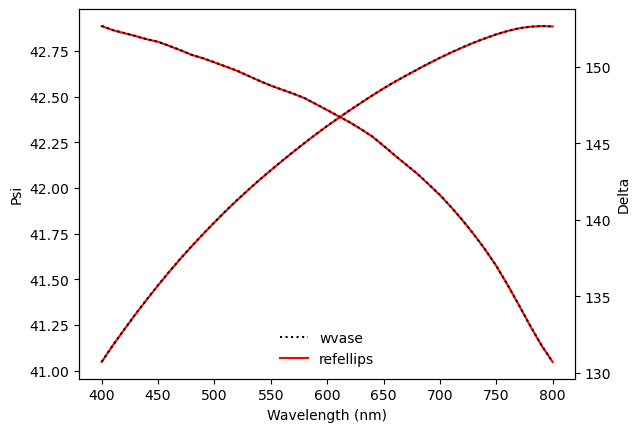

In [13]:
data = DataSE("WVASE_example_10nmSiO2_325nmAl2O3_MultiWavelength.txt")

si = RI("../materials/silicon.csv")
sio2 = RI("../materials/silica.csv")
al2o3 = RI("../materials/aluminium_oxide.csv")
air = RI("../materials/air.csv")

struc = air() | al2o3(3250) | sio2(100) | si()

model = ReflectModelSE(struc, delta_offset=0)
model._flip_delta = True

fig, ax = plt.subplots()
axt = ax.twinx()

wavelength, aoi, d_psi, d_delta = data.data
psi, delta = model(np.c_[wavelength, np.ones_like(wavelength) * aoi])

ax.plot(wavelength, d_psi, ls="dotted", color="k", label="wvase", zorder=3)
axt.plot(wavelength, d_delta, ls="dotted", color="k", zorder=3)
ax.plot(wavelength, psi, color="r", label="refellips")
axt.plot(wavelength, delta, color="r")

ax.legend(frameon=False, loc="lower center")
ax.set(ylabel="Psi", xlabel="Wavelength (nm)")
axt.set(ylabel="Delta")

assert_allclose(psi, d_psi, rtol=4e-5)
assert_allclose(delta, d_delta, rtol=2e-4)

# Test 10
A comparison to WVASE for a 3 nm SiO$_2$ and 90 nm polymer film in water with 20% solvent using the Maxwell-Garnett EMA method.

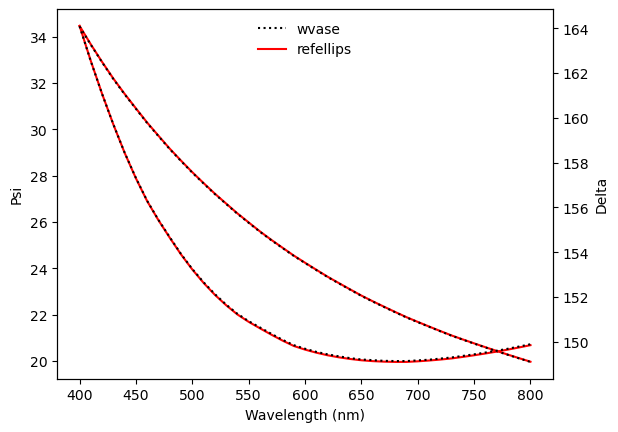

In [14]:
data = DataSE("WVASE_example_3nmSiO2_90nmPNIPAM_20EMA-MG_MultiWavelength.txt")

si = load_material("silicon")
sio2 = load_material("silica")
polymer = Cauchy(A=1.47, B=0.00495)
water = Cauchy(A=1.3242, B=0.003064)

polymer_layer = polymer(900)
polymer_layer.name = "PNIPAM"
polymer_layer.vfsolv.setp(value=0.2)

struc = water() | polymer_layer | sio2(30) | si()
struc.solvent = water
struc.ema = "maxwell-garnett"
struc.depolarisation_factor = 1 / 3

model = ReflectModelSE(struc, delta_offset=0)
model._flip_delta = True

fig, ax = plt.subplots()
axt = ax.twinx()

wavelength, aoi, d_psi, d_delta = data.data
psi, delta = model(np.c_[wavelength, np.ones_like(wavelength) * aoi])

ax.plot(wavelength, d_psi, ls="dotted", color="k", label="wvase", zorder=3)
axt.plot(wavelength, d_delta, ls="dotted", color="k", zorder=3)
ax.plot(wavelength, psi, color="r", label="refellips")
axt.plot(wavelength, delta, color="r")

ax.legend(frameon=False, loc="upper center")
ax.set(ylabel="Psi", xlabel="Wavelength (nm)")
axt.set(ylabel="Delta")

assert_allclose(psi, d_psi, rtol=7e-4)
assert_allclose(delta, d_delta, rtol=4e-4)

# Test 11
A comparison to WVASE for a 6 nm SiO$_2$ and 145 nm polymer film in water with 70% solvent using the Brugge EMA method.

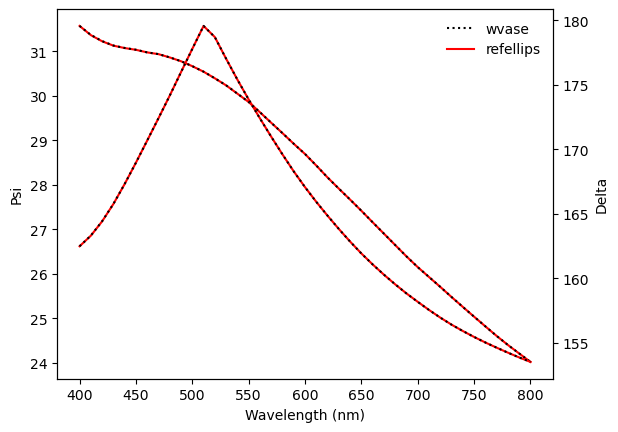

In [15]:
data = DataSE("WVASE_example_6nmSiO2_145nmPolymer_70EMA-BG_MultiWavelength.txt")

si = load_material("silicon")
sio2 = load_material("silica")
polymer = Cauchy(A=1.66, B=0.006)
water = load_material("water")

polymer_layer = polymer(1450)
polymer_layer.name = "PNIPAM"
polymer_layer.vfsolv.setp(value=0.70)

struc = water() | polymer_layer | sio2(60) | si()
struc.solvent = water
struc.ema = "bruggeman"
struc.depolarisation_factor = 0.2

model = ReflectModelSE(struc, delta_offset=0)
model._flip_delta = True

fig, ax = plt.subplots()
axt = ax.twinx()

wavelength, aoi, d_psi, d_delta = data.data
psi, delta = model(np.c_[wavelength, np.ones_like(wavelength) * aoi])

ax.plot(wavelength, d_psi, ls="dotted", color="k", label="wvase", zorder=3)
axt.plot(wavelength, d_delta, ls="dotted", color="k", zorder=3)
ax.plot(wavelength, psi, color="r", label="refellips")
axt.plot(wavelength, delta, color="r")

ax.legend(frameon=False, loc="upper right")
ax.set(ylabel="Psi", xlabel="Wavelength (nm)")
axt.set(ylabel="Delta")

assert_allclose(psi, d_psi, rtol=2e-4)
assert_allclose(delta, d_delta, rtol=7e-5)